In [20]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fft


Variable initialization

In [21]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [22]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    DCT[:, i] = fft.idct(a, norm='ortho')


Generating the 1-D canonical basis

In [23]:
for i in range(M):
    pass
#    C[:, i] = a
C = np.eye(M, M)

Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

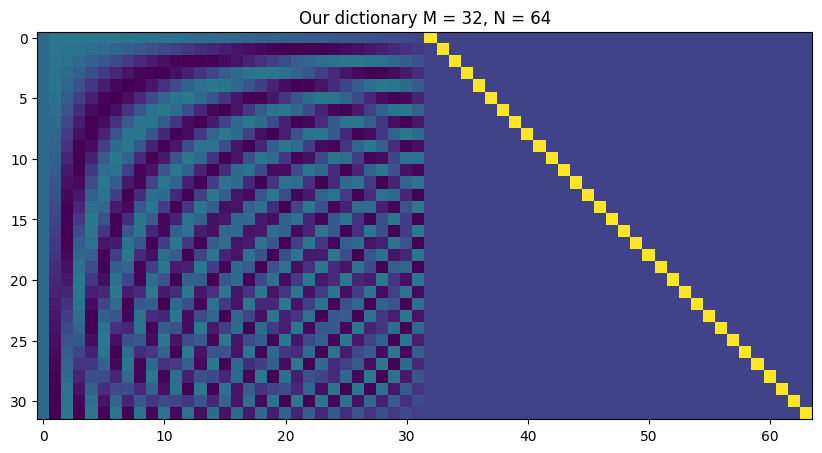

In [24]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to $\mathbf{s}$ that is sparse w.r.t. $C$. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [25]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $DCT$ (make sure the nonzero coefficients are sufficiently large)

In [26]:
# Sparsity
K = 5

In [27]:
x0 = np.zeros(N)
nonzeros_coeffs = np.random.choice(M, K)
x0[nonzeros_coeffs] = np.random.random(K)

x0_non_spiked = x0.copy()

Choose spike location

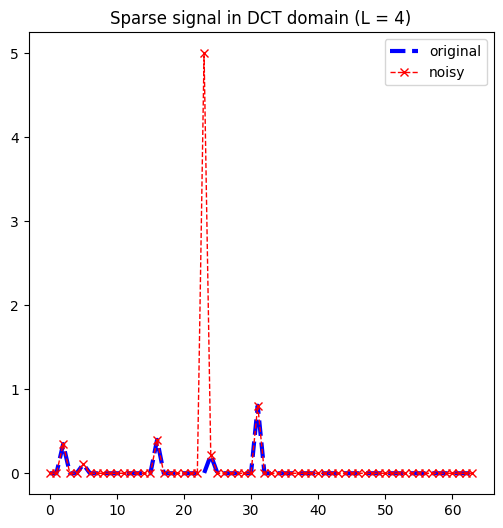

In [28]:
LN_WDT = 2
MRK_SZ = 10

spikeLocation = 23
x0[spikeLocation] = 5

plt.figure(figsize=(6, 6))
plt.plot(x0_non_spiked, 'b--', linewidth=LN_WDT+1)
plt.plot(x0, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Synthetize the corresponding signal in the signal domain and add noise


In [29]:
s0 = D @ x0
s = s0 + sigma_noise

Plot the sparse signal

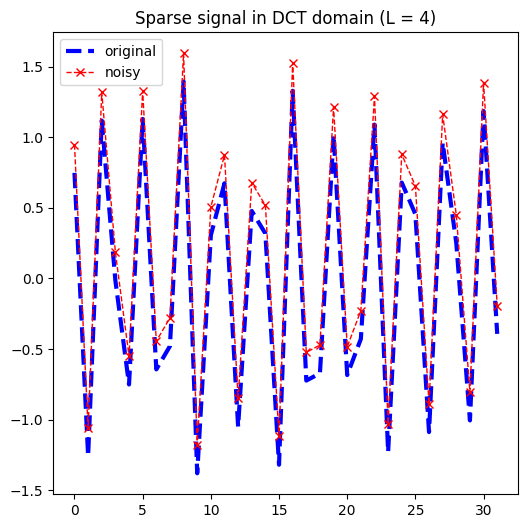

In [30]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [31]:
x_OMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [32]:
while np.count_nonzero(x_OMP) <= L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D

    # compute the correlation between the columns of D and the residual
    # this is like dj.T @ s = x
    correlation = D.T @ r

    # choose the highest correlation element
    j_star = np.argmax(np.abs(correlation))

    # update omega set with the index of the column found by argmax
    omega.append(j_star)

    # get omage set
    D_omega = D[:, omega]

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x_active, residuals, rank, s_A = np.linalg.lstsq(D_omega, s)
    x_OMP[omega] = x_active

    # update the residual
    r = s - D_omega @ x_active


x_OMP[omega] = x_active

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [33]:
s_hat_OMP = D @ x_OMP

Show the result

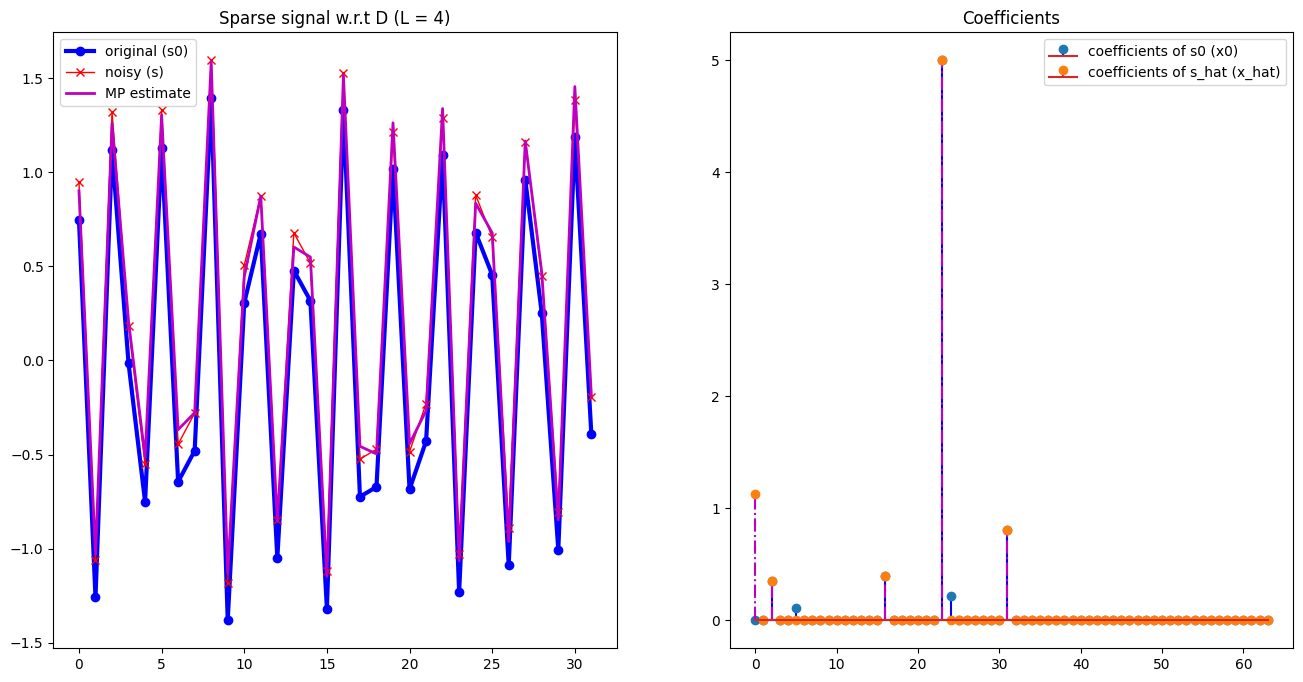

In [34]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [35]:
x_LSOMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [36]:
while np.count_nonzero(x_LSOMP) <= L:
    correlation = D.T @ r
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        jStar = np.argmax(np.abs(correlation))
        x_LSOMP[jStar] = correlation[jStar]
    else:
        # perform the sweep step by solving the LS problem
        # choose top k j
        J = np.argsort(np.abs(correlation))

        # UPDATE the support set with the jStar coefficient
        omega.extend(J)

        D_omega = D[:, omega]

        # Do least squares
        x_active, _, _ = np.linalg.lstsq(D_omega, s)

        # update the coefficients
        x_LSOMP = x_active

    # update the residual
    r = s - D @ x_LSOMP



SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [ ]:
s_hat_LSOMP = D @ x_LSOMP

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 64 is different from 5)

Show the result

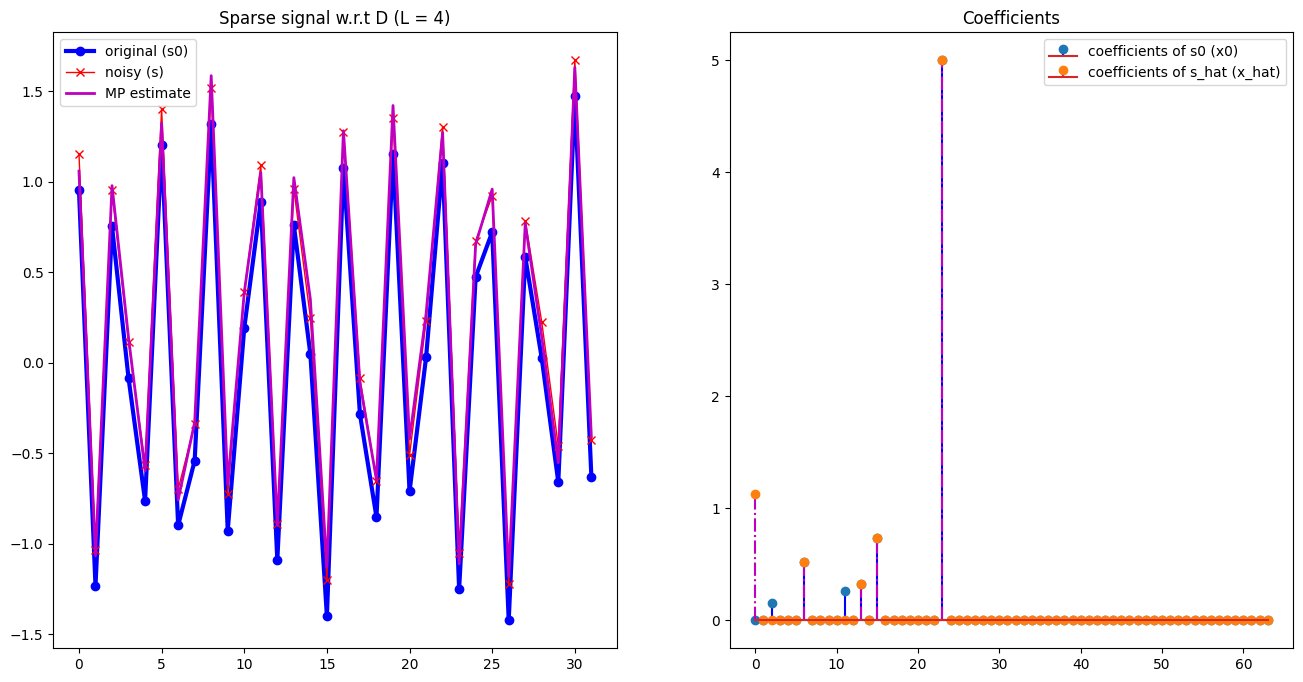

In [ ]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])